In [1]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
from dotenv import dotenv_values

In [2]:
# Load the environment variables from the .env file
env_vars = dotenv_values('.env')

# Get the password from the environment variables
password = env_vars.get('PASSWORD')

# Get the user from the environment variables
user = env_vars.get('USER')

In [3]:
if password:
    print("Password retrieved successfully")
else:
    print("Password not found in .env file.")

Password retrieved successfully


In [4]:
# Connect to the database
db = mysql.connector.connect(host="localhost",
                             user=user,
                             passwd=password,
                             database="gsalud")

# Create a cursor object using the cursor() method
cursor = db.cursor()

Get the number of activities of all appoinments

In [5]:
cursor.execute("SELECT COUNT(*) as count from activities_of_appointment")
activities_of_appointments = cursor.fetchall()
number_of_activities_of_appointments = activities_of_appointments[0][0]

print(
    f"Number of activities of appointments: {number_of_activities_of_appointments}"
)

Number of activities of appointments: 191


Get the number of appointments with only 1 activity

In [6]:
# Select appointments of activities_of_appointment with only one activity
appointments_single_activities = "SELECT appointment_id FROM activities_of_appointment GROUP BY appointment_id HAVING COUNT(*) = 1"
table_single_activities = f"SELECT * FROM activities_of_appointment WHERE appointment_id IN ({appointments_single_activities})"

# Create a view with the appointments with only one activity
cursor.execute(
    f"CREATE OR REPLACE VIEW v_single_activity_appointments AS {table_single_activities}"
)

# Select the number of appointments with only one activity
cursor.execute("SELECT COUNT(*) as count from v_single_activity_appointments")
number_of_single_activities = cursor.fetchall()[0][0]

print(
    f"Number of appointments with only one activity: {number_of_single_activities}"
)

Number of appointments with only one activity: 87


### Get join table of appointments with only 1 activity and its prices

In [7]:
# Join activity table with activities_of_appointment table with only one activity
columns = "v.appointment_id AS appointment_id, a.activity_id AS activity_id, a.name AS activity_name"
order = "ORDER BY v.appointment_id"
single_activities_with_names = f"SELECT {columns} FROM v_single_activity_appointments v JOIN activity a ON v.activity_id = a.activity_id {order}"

# Create view
cursor.execute(
    f"CREATE OR REPLACE VIEW v_single_activity_appointments_with_names AS {single_activities_with_names}"
)

In [8]:
# Join with appointment table
columns = """a.appointment_id AS appointment_id, v.activity_id AS activity_id, a.patient_id AS patient_id,
                v.activity_name AS activity_name, a.date AS date, a.value AS value, a.payment_method_id AS payment_method_id"""
j_appointment_single_activities = f"SELECT {columns} FROM v_single_activity_appointments_with_names v JOIN appointment a ON v.appointment_id = a.appointment_id"

# Create view
cursor.execute(
    f"CREATE OR REPLACE VIEW v_appointment_single_activities_full AS {j_appointment_single_activities} ORDER BY appointment_id"
)

In [9]:
# Create a dataframe from the view
df = pd.read_sql_query(f"SELECT * FROM v_appointment_single_activities_full",
                       db,
                       index_col="appointment_id",
                       parse_dates=["date"],
                       coerce_float=True)

df.head()

/tmp/ipykernel_28263/600516970.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(f"SELECT * FROM v_appointment_single_activities_full",


,activity_id,patient_id,activity_name,date,value,payment_method_id
appointment_id,,,,,,
0,1,1,valoracion,2023-06-09,60000,1
2,4,3,radiografia,2023-06-09,25000,3
4,5,5,control,2023-06-09,60000,1
5,7,6,bichectomia,2023-06-09,300000,2
9,12,9,faja,2023-06-09,180000,2


### Start EDA with the join table

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87 entries, 0 to 928
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   activity_id        87 non-null     int64         
 1   patient_id         87 non-null     int64         
 2   activity_name      87 non-null     object        
 3   date               87 non-null     datetime64[ns]
 4   value              87 non-null     int64         
 5   payment_method_id  87 non-null     int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 4.8+ KB


In [11]:
# Get df of only activities and values
df_activities = df[["activity_name", "value"]]

In [12]:
# Set a better pandas format for the values
pd.options.display.float_format = '{:,.2f}'.format

In [13]:
print("Numerical columns:")
df_activities.describe(include=np.number)

Numerical columns:


,value
count,87.00
mean,"120,287.36"
std,"143,910.09"
min,"4,000.00"
25%,"50,000.00"
50%,"60,000.00"
75%,"100,000.00"
max,"800,000.00"


In [14]:
print("Categorical columns:")
df_activities.describe(include=object)

Categorical columns:


,activity_name
count,87
unique,18
top,control
freq,34


Plot general price distribution

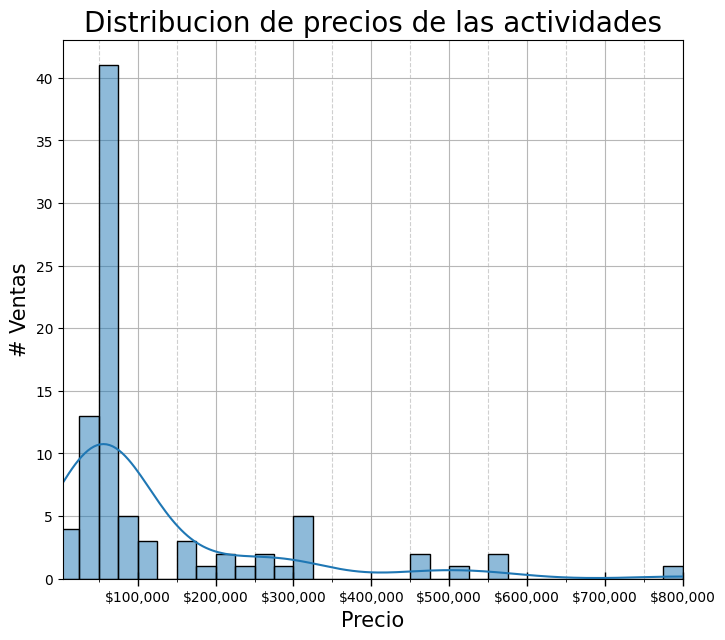

In [15]:
# Plot the distribution of the value column
plt.figure(figsize=(8, 7))
# Put bins every 25k
bins = np.arange(0, df_activities["value"].max() + 25000, 25000)
# Plot histogram
sns.histplot(df_activities["value"], bins=bins, kde=True, zorder=2)
# Set x limits
plt.xlim(min(df_activities["value"]), max(df_activities["value"]))
# Set minor ticks on x axis (ticks between the bars)
plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(50000))
# Format x ticks as currency
plt.gca().xaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, _: f"${x:,.0f}"))
# Rotate x labels
# plt.xticks(rotation=45)
# Set title
plt.title("Distribucion de precios de las actividades",
          fontdict={"fontsize": 20})
# Set x label
plt.xlabel("Precio", fontdict={"fontsize": 15})
# Set y label
plt.ylabel("# Ventas", fontdict={"fontsize": 15})
plt.gca().tick_params(axis='x',
                      which='major',
                      width=1,
                      length=10,
                      direction='inout')
# Show grid
plt.grid(True, which="minor", linestyle="--", alpha=0.6)
plt.grid(True, which="major", linestyle="-", alpha=0.9)
plt.savefig("Images/dist_precios_actividades.png")
plt.show()

Plot a treemap of the revenue of each activity

In [16]:
# Group by activity name and sum the values, put the values after the top 9 into "Other"
df_activities_pbi = df_activities.groupby("activity_name").sum().sort_values(
    by="value", ascending=False)
df_activities_pbi = df_activities_pbi.reset_index()
# Add the "otros" category
df_activities_pbi.loc[9] = ["otros", df_activities_pbi["value"][9:].sum()]
# Delete the rows after the top 9 which are now in "otros"
df_activities_pbi = df_activities_pbi.drop(df_activities_pbi.index[10:])

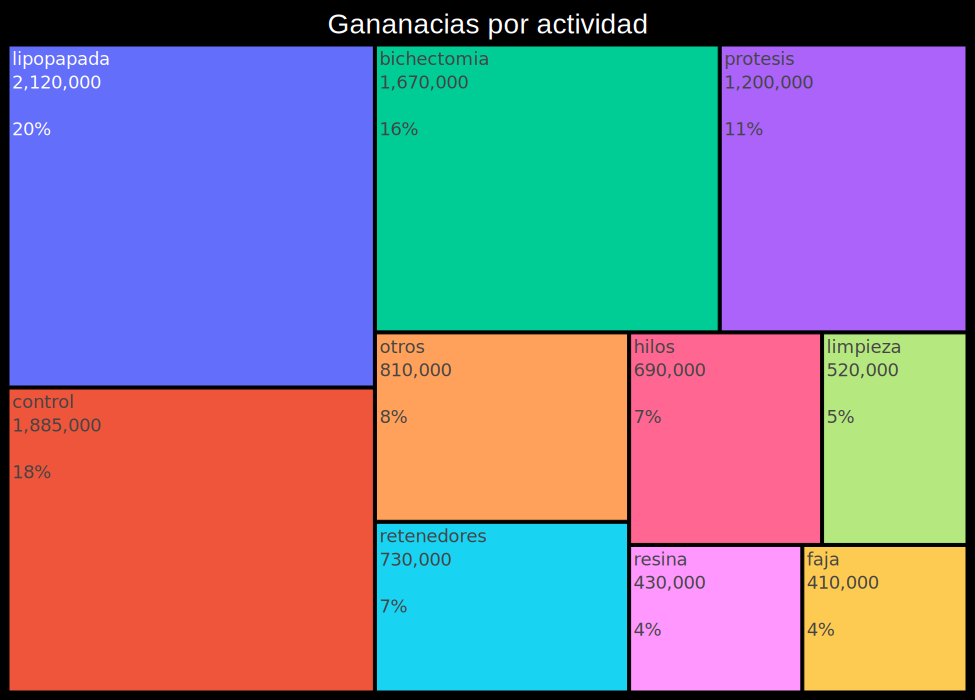

In [17]:
# Plot treemap of the activities that generate the most revenue
fig = go.Figure(
    go.Treemap(labels=df_activities_pbi["activity_name"],
               parents=[""] * 10,
               values=df_activities_pbi["value"],
               textinfo="label+value+percent entry"))
# Set the font size
fig.update_layout(font=dict(size=18))
# Set the title properties
fig.update_layout(title="Gananacias por actividad",
                  title_x=0.5,
                  title_y=0.98,
                  title_font=dict(size=28,
                                  family="Arial, sans-serif",
                                  color="white"),
                  paper_bgcolor="black",
                  margin=dict(l=0, r=0, t=10, b=0))
# Set size of the figure
fig.update_layout(autosize=False, width=975, height=700)
# Save the figure
fig.write_image("Images/ganancias_por_actividad.png")
# Show the figure
fig.show(renderer="svg")
# Finish figure
plt.show()

### Get price distribution of each activity

In [18]:
# Get means, standard deviations and quantiles of the value column for each activity
activities_values_describe = df_activities.groupby("activity_name").agg(
    ["count", "mean", "std", "min", "max", "quantile"])
activities_values_describe

value                                        \
                         count       mean        std     min     max   
activity_name                                                          
Consulta General             1  60,000.00        NaN   60000   60000   
Placa Activada               1 100,000.00        NaN  100000  100000   
Tratamiento Odontologico     1 150,000.00        NaN  150000  150000   
bichectomia                  6 278,333.33  53,072.28  170000  300000   
calsa                        1  70,000.00        NaN   70000   70000   
control                     34  55,441.18  13,337.56    4000   65000   
extraccion                   2 100,000.00       0.00  100000  100000   
faja                         8  51,250.00  52,491.50   30000  180000   
hilos                        2 345,000.00 162,634.56  230000  460000   
kit                          2  20,000.00       0.00   20000   20000   
limpieza                     8  65,000.00  16,035.67   50000   80000   
lipopapada                   5 424,000.00 151,261.36  250000  550000   
protesis                     3 400,000.00 346,410.16  200000  800000   
radiografia                  4  25,000.00       0.00   25000   25000   
reparacion                   1  30,000.00        NaN   30000   30000   
resina                       3 143,333.33 118,462.37   70000  280000   
retenedores                  4 182,500.00 189,802.53   60000  460000   
valoracion                   1  60,000.00        NaN   60000   60000   

                                     
                           quantile  
activity_name                        
Consulta General          60,000.00  
Placa Activada           100,000.00  
Tratamiento Odontologico 150,000.00  
bichectomia              300,000.00  
calsa                     70,000.00  
control                   60,000.00  
extraccion               100,000.00  
faja                      30,000.00  
hilos                    345,000.00  
kit                       20,000.00  
limpieza                  65,000.00  
lipopapada               500,000.00  
protesis                 200,000.00  
radiografia               25,000.00  
reparacion                30,000.00  
resina                    80,000.00  
retenedores              105,000.00  
valoracion                60,000.00

In [19]:
# Set NaN values to 0 for the standard deviation
activities_values_describe[("value", "std")] = activities_values_describe[(
    "value", "std")].fillna(0)

# Create a dataframe with the activity name and value for the activities values of standard deviation = 0
activities_values_describe_no_std = activities_values_describe[(
    activities_values_describe["value", "std"] == 0)]

activities_values = activities_values_describe_no_std["value"][["mean"]]
# Change the name of the column mean to value and its type to int
activities_values.columns = ["value"]
activities_values = activities_values.astype(int)
activities_values

,value
activity_name,
Consulta General,60000
Placa Activada,100000
Tratamiento Odontologico,150000
calsa,70000
extraccion,100000
kit,20000
radiografia,25000
reparacion,30000
valoracion,60000


In [20]:
# Get the rest of activities with standard deviation different from 0
activities_values_describe_std = activities_values_describe[(
    activities_values_describe["value", "std"] != 0)].copy()

# Add a normalized standard deviation column
activities_values_describe_std[(
    "value", "std_normalized")] = activities_values_describe_std[
        ("value", "std")] / activities_values_describe_std[("value", "mean")]

# Sort the activities by the normalized standard deviation
activities_values_describe_std = activities_values_describe_std.sort_values(
    by=("value", "std_normalized"), ascending=False)

activities_values_describe_std

value                                                   \
              count       mean        std     min     max   quantile   
activity_name                                                          
retenedores       4 182,500.00 189,802.53   60000  460000 105,000.00   
faja              8  51,250.00  52,491.50   30000  180000  30,000.00   
protesis          3 400,000.00 346,410.16  200000  800000 200,000.00   
resina            3 143,333.33 118,462.37   70000  280000  80,000.00   
hilos             2 345,000.00 162,634.56  230000  460000 345,000.00   
lipopapada        5 424,000.00 151,261.36  250000  550000 500,000.00   
limpieza          8  65,000.00  16,035.67   50000   80000  65,000.00   
control          34  55,441.18  13,337.56    4000   65000  60,000.00   
bichectomia       6 278,333.33  53,072.28  170000  300000 300,000.00   

                              
              std_normalized  
activity_name                 
retenedores             1.04  
faja                    1.02  
protesis                0.87  
resina                  0.83  
hilos                   0.47  
lipopapada              0.36  
limpieza                0.25  
control                 0.24  
bichectomia             0.19

In [21]:
def IQR(df, activity_name):
    Q1 = df[df["activity_name"] == activity_name]["value"].quantile(0.25)
    Q3 = df[df["activity_name"] == activity_name]["value"].quantile(0.75)
    return Q3 - Q1

In [22]:
# Get the IQR for each activity
activities_values_describe_std[("value",
                                "IQR")] = activities_values_describe_std.apply(
                                    lambda x: IQR(df_activities, x.name),
                                    axis=1)

activities_values_describe_std

value                                                   \
              count       mean        std     min     max   quantile   
activity_name                                                          
retenedores       4 182,500.00 189,802.53   60000  460000 105,000.00   
faja              8  51,250.00  52,491.50   30000  180000  30,000.00   
protesis          3 400,000.00 346,410.16  200000  800000 200,000.00   
resina            3 143,333.33 118,462.37   70000  280000  80,000.00   
hilos             2 345,000.00 162,634.56  230000  460000 345,000.00   
lipopapada        5 424,000.00 151,261.36  250000  550000 500,000.00   
limpieza          8  65,000.00  16,035.67   50000   80000  65,000.00   
control          34  55,441.18  13,337.56    4000   65000  60,000.00   
bichectomia       6 278,333.33  53,072.28  170000  300000 300,000.00   

                                         
              std_normalized        IQR  
activity_name                            
retenedores             1.04 167,500.00  
faja                    1.02   5,000.00  
protesis                0.87 300,000.00  
resina                  0.83 105,000.00  
hilos                   0.47 115,000.00  
lipopapada              0.36 280,000.00  
limpieza                0.25  30,000.00  
control                 0.24       0.00  
bichectomia             0.19       0.00

From here, we can deduct that both control and bichectomia have a value of 60k with some outliers, se we remove them of the analizing dataset and add into the consolidate one

In [23]:
# Add control and bichectomia to activity values with the value of the quantile
activities_values.loc["control"] = activities_values_describe_std.loc[
    "control", ("value", "quantile")].astype(int)
activities_values.loc["bichectomia"] = activities_values_describe_std.loc[
    "bichectomia", ("value", "quantile")].astype(int)

# Now remove them from the activities_values_describe_std dataframe
activities_values_describe_std = activities_values_describe_std.drop(
    ["control", "bichectomia"])

activities_values_describe_std

value                                                   \
              count       mean        std     min     max   quantile   
activity_name                                                          
retenedores       4 182,500.00 189,802.53   60000  460000 105,000.00   
faja              8  51,250.00  52,491.50   30000  180000  30,000.00   
protesis          3 400,000.00 346,410.16  200000  800000 200,000.00   
resina            3 143,333.33 118,462.37   70000  280000  80,000.00   
hilos             2 345,000.00 162,634.56  230000  460000 345,000.00   
lipopapada        5 424,000.00 151,261.36  250000  550000 500,000.00   
limpieza          8  65,000.00  16,035.67   50000   80000  65,000.00   

                                         
              std_normalized        IQR  
activity_name                            
retenedores             1.04 167,500.00  
faja                    1.02   5,000.00  
protesis                0.87 300,000.00  
resina                  0.83 105,000.00  
hilos                   0.47 115,000.00  
lipopapada              0.36 280,000.00  
limpieza                0.25  30,000.00

Limpieza also seems to have a fixed base value of 65k, so we also add it to the consolidate dataset

In [24]:
# Add limpieza to activity values with the value of the quantile
activities_values.loc["limpieza"] = activities_values_describe_std.loc[
    "limpieza", ("value", "quantile")].astype(int)

# Now remove it from the activities_values_describe_std dataframe
activities_values_describe_std = activities_values_describe_std.drop(
    ["limpieza"])

activities_values_describe_std

value                                                   \
              count       mean        std     min     max   quantile   
activity_name                                                          
retenedores       4 182,500.00 189,802.53   60000  460000 105,000.00   
faja              8  51,250.00  52,491.50   30000  180000  30,000.00   
protesis          3 400,000.00 346,410.16  200000  800000 200,000.00   
resina            3 143,333.33 118,462.37   70000  280000  80,000.00   
hilos             2 345,000.00 162,634.56  230000  460000 345,000.00   
lipopapada        5 424,000.00 151,261.36  250000  550000 500,000.00   

                                         
              std_normalized        IQR  
activity_name                            
retenedores             1.04 167,500.00  
faja                    1.02   5,000.00  
protesis                0.87 300,000.00  
resina                  0.83 105,000.00  
hilos                   0.47 115,000.00  
lipopapada              0.36 280,000.00

The rest of the activities seem to have a very wide range of values, which may mean that there are different subcategories of the same activity or different numbers of procedures per activity. So we will leave them as they are and only use the consolidate dataset for the price list.

In [25]:
# Get name of activities with variable prices
activities_dist = activities_values_describe_std.index.to_list()

# Create a dataframe for them
df_activities_dist = df_activities[df_activities["activity_name"].isin(
    activities_dist)].copy()

# Create a dataframe of the activities with fixes prices
df_activities_fixed = df_activities[~df_activities["activity_name"].
                                    isin(activities_dist)].copy()

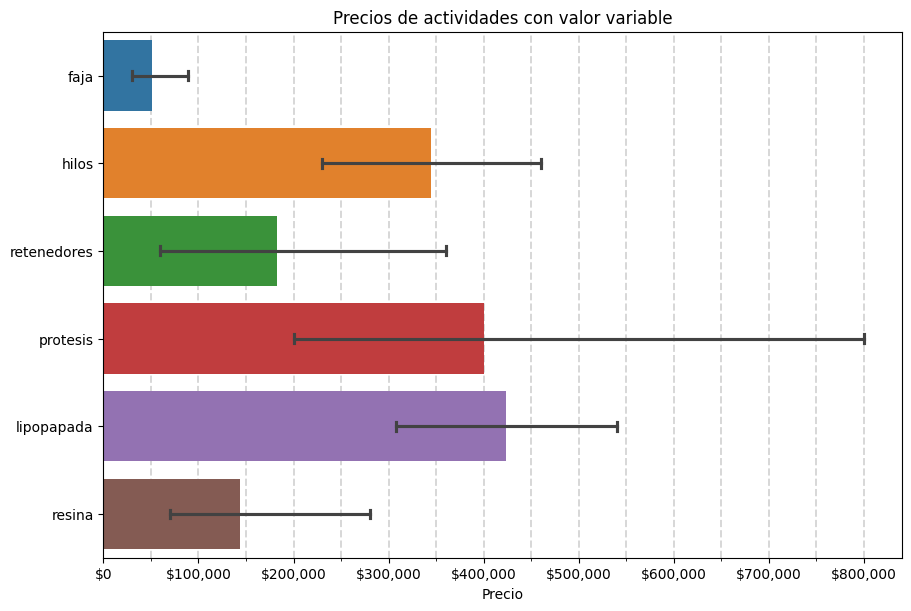

In [26]:
fig, ax = plt.subplots(figsize=(9, 6), constrained_layout=True)
sns.barplot(data=df_activities_dist,
            y="activity_name",
            x="value",
            hue="activity_name",
            capsize=0.1,
            ax=ax,
            zorder=2)
# Set x and y labels
ax.set_title("Precios de actividades con valor variable")
ax.set_xlabel("Precio")
ax.set_ylabel("")
# Apply currency format to the x axis
ax.xaxis.set_major_formatter('${x:,.0f}')
# Set mayor locator to 200000
ax.xaxis.set_major_locator(plt.MultipleLocator(100000))
# Increase number of minor ticks on x axis
ax.xaxis.set_minor_locator(plt.MultipleLocator(50000))
# Add grid
ax.grid(True, which="both", linestyle="--", axis="x", alpha=0.5, linewidth=1.4)
# Save the figure
plt.savefig("Images/precios_actividades_variable.png")
plt.show()

Here we remove `Tratamiento Odontologico` as it most likely is a category of activities and not an activity itself 

In [27]:
# Remove "Tratamiento Odontologico" from the df_activities_fixed
df_activities_fixed = df_activities_fixed[df_activities_fixed["activity_name"]
                                          != "Tratamiento Odontologico"]

Now we graph the price distribution of the activities in the consolidate dataset

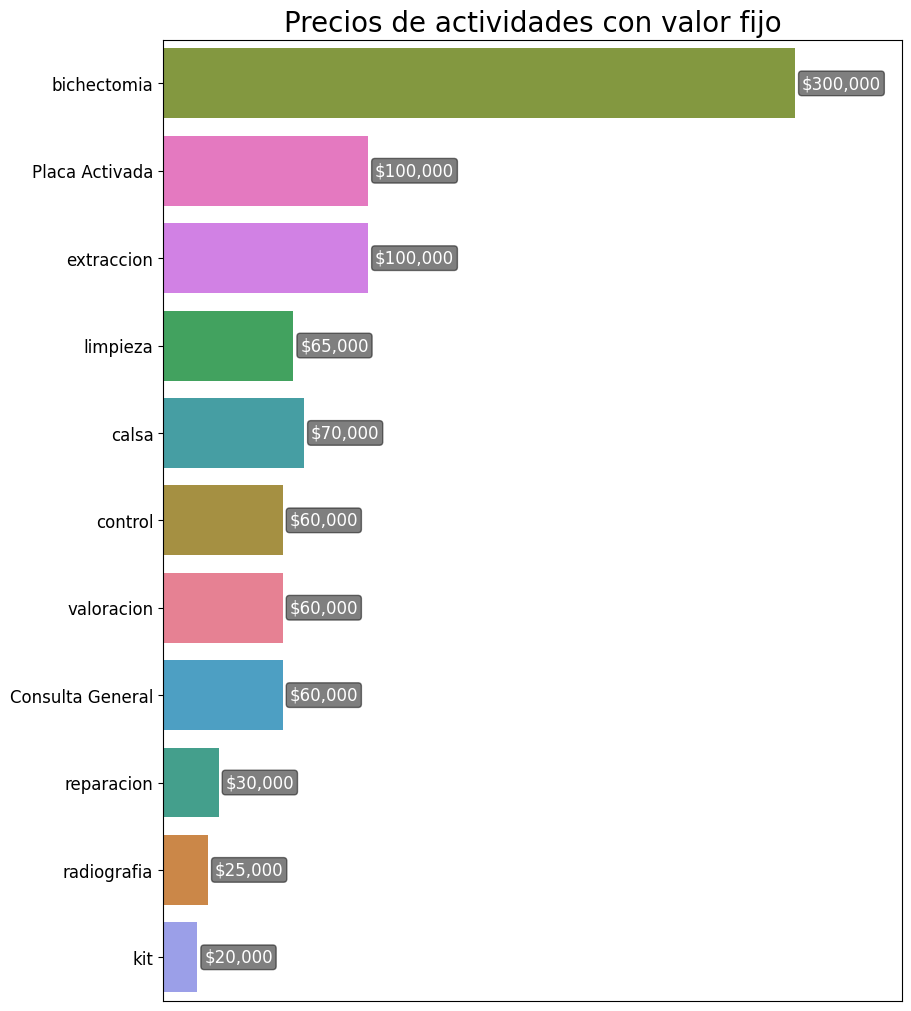

In [28]:
fig = plt.figure(figsize=(9, 10), constrained_layout=True)
ax = sns.barplot(
    data=df_activities_fixed,
    y="activity_name",
    x="value",
    # Use the mode as estimator
    estimator="median",
    hue="activity_name",
    errorbar=None,
    # Sort the bars by value
    order=df_activities_fixed.sort_values("value",
                                          ascending=False).activity_name,
    zorder=2)
plt.title("Precios de actividades con valor fijo", fontdict={"fontsize": 20})
plt.xlabel("")
plt.ylabel("")
plt.yticks(fontsize=12)

# Set x limits
plt.xlim(min(df_activities_fixed["value"]),
         max(df_activities_fixed["value"] + 50000))

# Remove x-axis labels
ax.set_xticklabels([])

# Remove x-axis tick lines
plt.gca().tick_params(axis='x', bottom=False)

# Annotate each bar with its value with background on the labels
for p in ax.patches:
    ax.annotate(f"${int(p.get_width()):,d}",
                (p.get_width(), p.get_y() + p.get_height() / 2),
                ha="left",
                va="center",
                fontsize=12,
                color="white",
                xytext=(5, 0),
                textcoords="offset points",
                bbox=dict(facecolor='black',
                          alpha=0.5,
                          boxstyle="round,pad=0.2"))
# Save the figure
plt.savefig("Images/precios_actividades_fijo.png")
plt.show()

Now with the analisy of the activities finished, we can start analizing revenew by day and other variables

In [29]:
# Get value per weekday
cursor.execute(
    "SELECT  WEEKDAY(date) as weekday, SUM(value) as revenew FROM appointment GROUP BY weekday ORDER BY weekday"
)

weekday_revenew = pd.DataFrame(cursor.fetchall(),
                               columns=["weekday", "revenew"])

In [30]:
# Add column with weekday name in spanish
weekday_revenew["weekday_name"] = [
    "Lunes", "Martes", "Miércoles", "Jueves", "Viernes", "Sábado"
]

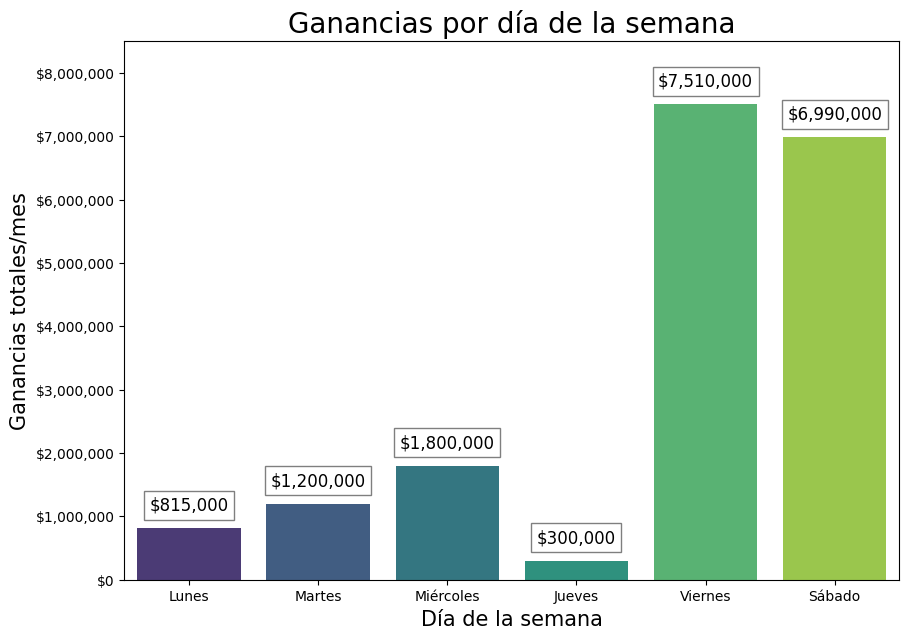

In [31]:
# Plot the value per weekday
plt.figure(figsize=(10, 7))
# Plot bar chart
sns.barplot(data=weekday_revenew,
            x="weekday_name",
            y="revenew",
            hue="weekday_name",
            palette="viridis",
            zorder=2)
# Set title
plt.title("Ganancias por día de la semana", fontdict={"fontsize": 20})
# Set x label
plt.xlabel("Día de la semana", fontdict={"fontsize": 15})
# Set y label
plt.ylabel("Ganancias totales/mes", fontdict={"fontsize": 15})
# Set y axis limits
plt.ylim(0, weekday_revenew["revenew"].max() + 1000000)
# Apply currency format to y axis
plt.gca().yaxis.set_major_formatter('${x:,.0f}')
# Annotate each bar with its value
for p in plt.gca().patches:
    # Get the height of the bar
    height = p.get_height()
    # Add text annotation inside the bar
    plt.gca().annotate(
        '${:,.0f}'.format(height),
        (p.get_x() + p.get_width() / 2, height),
        ha="center",
        va="bottom",
        fontsize=12,
        color="black",
        xytext=(0, 10),  # Adjust vertical position of the label
        textcoords="offset points",
        bbox=dict(facecolor="white", alpha=0.5))
# Save the figure
plt.savefig("Images/ganancias_por_dia_semana.png")
plt.show()

In [32]:
# Get mean sale value per weekday
cursor.execute(
    "SELECT  WEEKDAY(date) as weekday, AVG(value) as mean_value FROM appointment GROUP BY weekday ORDER BY weekday"
)

weekday_mean_sale = pd.DataFrame(cursor.fetchall(),
                                 columns=["weekday", "mean_value"])

In [33]:
# Add column with weekday name in spanish
weekday_mean_sale["weekday_name"] = [
    "Lunes", "Martes", "Miércoles", "Jueves", "Viernes", "Sábado"
]

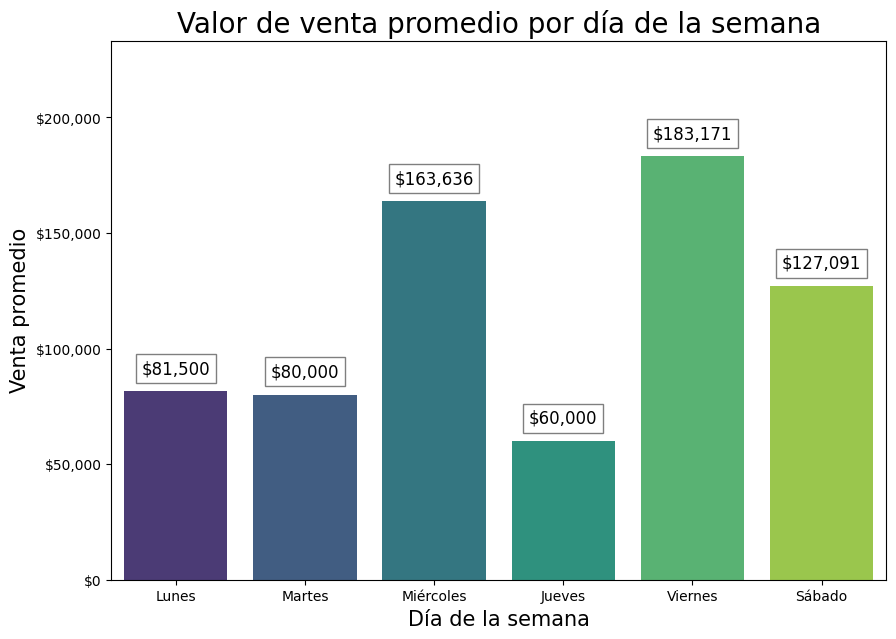

In [34]:
# Plot the mean sales value per weekday
plt.figure(figsize=(10, 7))
# Plot bar chart
sns.barplot(data=weekday_mean_sale,
            x="weekday_name",
            y="mean_value",
            hue="weekday_name",
            palette="viridis",
            zorder=2)
# Set title
plt.title("Valor de venta promedio por día de la semana",
          fontdict={"fontsize": 20})
# Set x label
plt.xlabel("Día de la semana", fontdict={"fontsize": 15})
# Set y label
plt.ylabel("Venta promedio", fontdict={"fontsize": 15})
# Set y axis limits
plt.ylim(0, weekday_mean_sale["mean_value"].max() + 50000)
# Apply currency format to y axis
plt.gca().yaxis.set_major_formatter('${x:,.0f}')
# Increase number of minor ticks on y axis
plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(50000))
# Annotate each bar with its value
for p in plt.gca().patches:
    # Get the height of the bar
    height = p.get_height()
    # Add text annotation inside the bar
    plt.gca().annotate(
        '${:,.0f}'.format(height),
        (p.get_x() + p.get_width() / 2, height),
        ha="center",
        va="bottom",
        fontsize=12,
        color="black",
        xytext=(0, 10),  # Adjust vertical position of the label
        textcoords="offset points",
        bbox=dict(facecolor="white", alpha=0.5))
# Save the figure
plt.savefig("Images/venta_promedio_por_dia_semana.png")
plt.show()

In [35]:
# Get mean sales value for each weekday

# Get the value of the sales for each day
sales_per_day = "SELECT date, SUM(value) as revenew FROM appointment GROUP BY date ORDER BY date"

# Get the average value of the sales for each day of the week
cursor.execute(
    f"SELECT WEEKDAY(date) as weekday, AVG(revenew) as mean_revenew FROM ({sales_per_day}) as sales_per_day GROUP BY weekday ORDER BY weekday"
)

mean_sales_per_weekday = pd.DataFrame(cursor.fetchall(),
                                      columns=["weekday", "mean_revenew"])

In [36]:
# Add column with weekday name in spanish
mean_sales_per_weekday["weekday_name"] = [
    "Lunes", "Martes", "Miércoles", "Jueves", "Viernes", "Sábado"
]

In [37]:
mean_sales_per_weekday

,weekday,mean_revenew,weekday_name
0,0,815000.0000,Lunes
1,1,600000.0000,Martes
2,2,900000.0000,Miércoles
3,3,150000.0000,Jueves
4,4,1877500.0000,Viernes
5,5,2330000.0000,Sábado


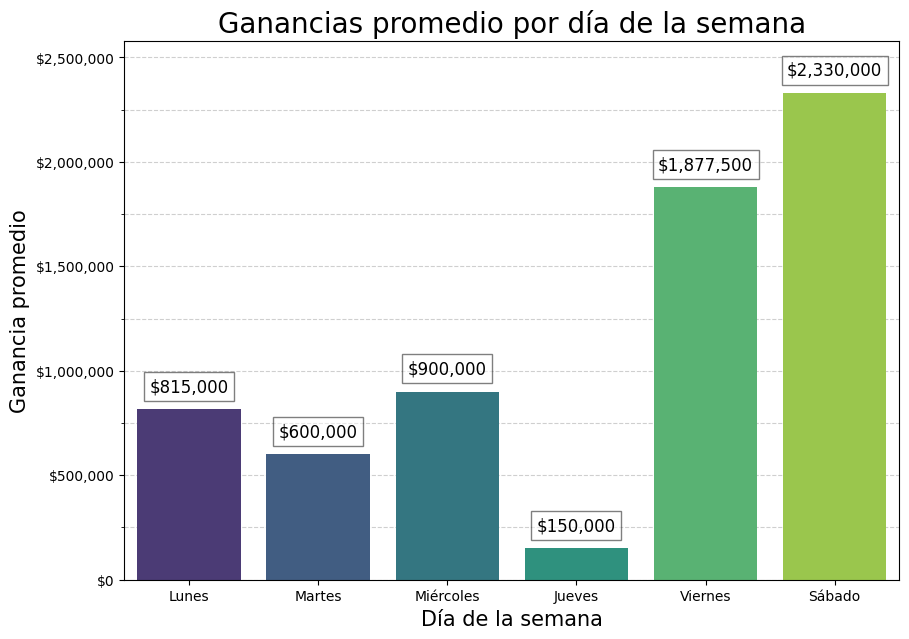

In [38]:
# Plot the mean value per weekday
plt.figure(figsize=(10, 7))
# Plot bar chart
sns.barplot(data=mean_sales_per_weekday,
            x="weekday_name",
            y="mean_revenew",
            hue="weekday_name",
            palette="viridis",
            zorder=2)
# Set title
plt.title("Ganancias promedio por día de la semana", fontdict={"fontsize": 20})
# Set x label
plt.xlabel("Día de la semana", fontdict={"fontsize": 15})
# Set y label
plt.ylabel("Ganancia promedio", fontdict={"fontsize": 15})
# Set y axis limits
plt.ylim(0, mean_sales_per_weekday["mean_revenew"].max() + 250000)
# Apply currency format to y axis
plt.gca().yaxis.set_major_formatter('${x:,.0f}')
# Increase number of minor ticks on y axis
plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(250000))
# Add grid
plt.grid(True, which="both", axis="y", linestyle="--", alpha=0.6)
# Annotate each bar with its value
for p in plt.gca().patches:
    # Get the height of the bar
    height = p.get_height()
    # Add text annotation inside the bar
    plt.gca().annotate(
        '${:,.0f}'.format(height),
        (p.get_x() + p.get_width() / 2, height),
        ha="center",
        va="bottom",
        fontsize=12,
        color="black",
        xytext=(0, 10),  # Adjust vertical position of the label
        textcoords="offset points",
        bbox=dict(facecolor="white", alpha=0.5))
# Save the figure
plt.show()